In [1]:
import json
import matplotlib.pyplot as plt

import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import model
import evaluator
import time

import sys

from pathlib import Path

%matplotlib notebook

In [2]:
!rm -r x86_64
!nrnivmodl mechanisms

which: no xcrun in (/gpfs/bbp.cscs.ch/ssd/apps/hpc/jenkins/deploy/externals/2021-01-06/linux-rhel7-x86_64/gcc-9.3.0/python-3.8.3-suxrst/bin:/gpfs/bbp.cscs.ch/ssd/apps/hpc/jenkins/deploy/externals/2021-01-06/linux-rhel7-x86_64/gcc-9.3.0/hpe-mpi-2.22.hmpt-r52ypu/bin:/gpfs/bbp.cscs.ch/home/damart/venv_lfpy/bin:/opt/clmgr/sbin:/opt/clmgr/bin:/opt/sgi/sbin:/opt/sgi/bin:/usr/lib64/qt-3.3/bin:/gpfs/bbp.cscs.ch/home/damart//.nix-profile/bin:/nix/var/nix/profiles/default/bin:/usr/lib64/ccache:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/gpfs/bbp.cscs.ch/ssd/apps/bb5/systemtools:/opt/c3/bin:/opt/ddn/scalers/tools:/usr/lpp/mmfs/bin:/opt/ddn/gs/scripts:/opt/ddn/gs/bin:/opt/ibutils/bin:/opt/ddn/ime/bin:/sbin:/bin)
/gpfs/bbp.cscs.ch/project/proj38/home/damart/test_LFpy/multimodalfitting/hay_model
Mod files: "mechanisms/CaDynamics_E2.mod" "mechanisms/Ca_HVA.mod" "mechanisms/Ca_LVAst.mod" "mechanisms/epsp.mod" "mechanisms/Ih.mod" "mechanisms/Im.mod" "mechanisms/K_Pst.mod" "mechanisms/K_Tst.mod" 

Translating SKv3_1.mod into /gpfs/bbp.cscs.ch/project/proj38/home/damart/test_LFpy/multimodalfitting/hay_model/x86_64/SKv3_1.c
 -> Compiling Ca_HVA.c
/gpfs/bbp.cscs.ch/ssd/apps/hpc/jenkins/deploy/compilers/2021-01-06/linux-rhel7-x86_64/gcc-4.8.5/gcc-9.3.0-45gzrp/bin/gcc -O2   -I"../mechanisms" -I.   -I/gpfs/bbp.cscs.ch/home/damart/venv_lfpy/lib/python3.8/site-packages/neuron/.data/include  -I/nrnwheel/openmpi/include -fPIC -c Ca_HVA.c -o Ca_HVA.o
Thread Safe
Thread Safe
 -> Compiling Ca_LVAst.c
/gpfs/bbp.cscs.ch/ssd/apps/hpc/jenkins/deploy/compilers/2021-01-06/linux-rhel7-x86_64/gcc-4.8.5/gcc-9.3.0-45gzrp/bin/gcc -O2   -I"../mechanisms" -I.   -I/gpfs/bbp.cscs.ch/home/damart/venv_lfpy/lib/python3.8/site-packages/neuron/.data/include  -I/nrnwheel/openmpi/include -fPIC -c Ca_LVAst.c -o Ca_LVAst.o
 -> Compiling epsp.c
/gpfs/bbp.cscs.ch/ssd/apps/hpc/jenkins/deploy/compilers/2021-01-06/linux-rhel7-x86_64/gcc-4.8.5/gcc-9.3.0-45gzrp/bin/gcc -O2   -I"../mechanisms" -I.   -I/gpfs/bbp.cscs.ch/hom

In [8]:
probe = None #model.define_electrode(probe_type="linear")

In [9]:
cell = model.create(morph_modifier="hillock", release=True)

param_names = [param.name for param in cell.params.values() if not param.frozen]

fitness_protocols = evaluator.define_protocols(
    feature_set=None, 
    feature_file=None, 
    electrode=probe,
    protocols_with_lfp=None
)

fitness_calculator = ephys.objectivescalculators.ObjectivesCalculator([])

sim = ephys.simulators.LFPySimulator(cell, cvode_active=True, electrode=probe)

eva = ephys.evaluators.CellEvaluator(                    
        cell_model=cell,                                                       
        param_names=param_names,                                                    
        fitness_protocols=fitness_protocols,                                        
        fitness_calculator=fitness_calculator,                                      
        sim=sim)

In [10]:
fitness_protocols

{'bAP': <bluepyopt.ephys.protocols.SweepProtocol at 0x7fff2228d880>,
 'BAC': <bluepyopt.ephys.protocols.SweepProtocol at 0x7fff219def40>,
 'EPSP': <bluepyopt.ephys.protocols.SweepProtocol at 0x7fff219c2220>,
 'CaBurst': <bluepyopt.ephys.protocols.SweepProtocol at 0x7fff219c2490>,
 'Step1': <bluepyopt.ephys.protocols.SweepProtocol at 0x7fff219c2700>}

In [11]:
t_start = time.time()
responses = eva.run_protocols(protocols=fitness_protocols.values(), param_values={})
print(f"Elapsed time: {time.time() - t_start}")

Elapsed time: 39.04744625091553


<IPython.core.display.Javascript object>


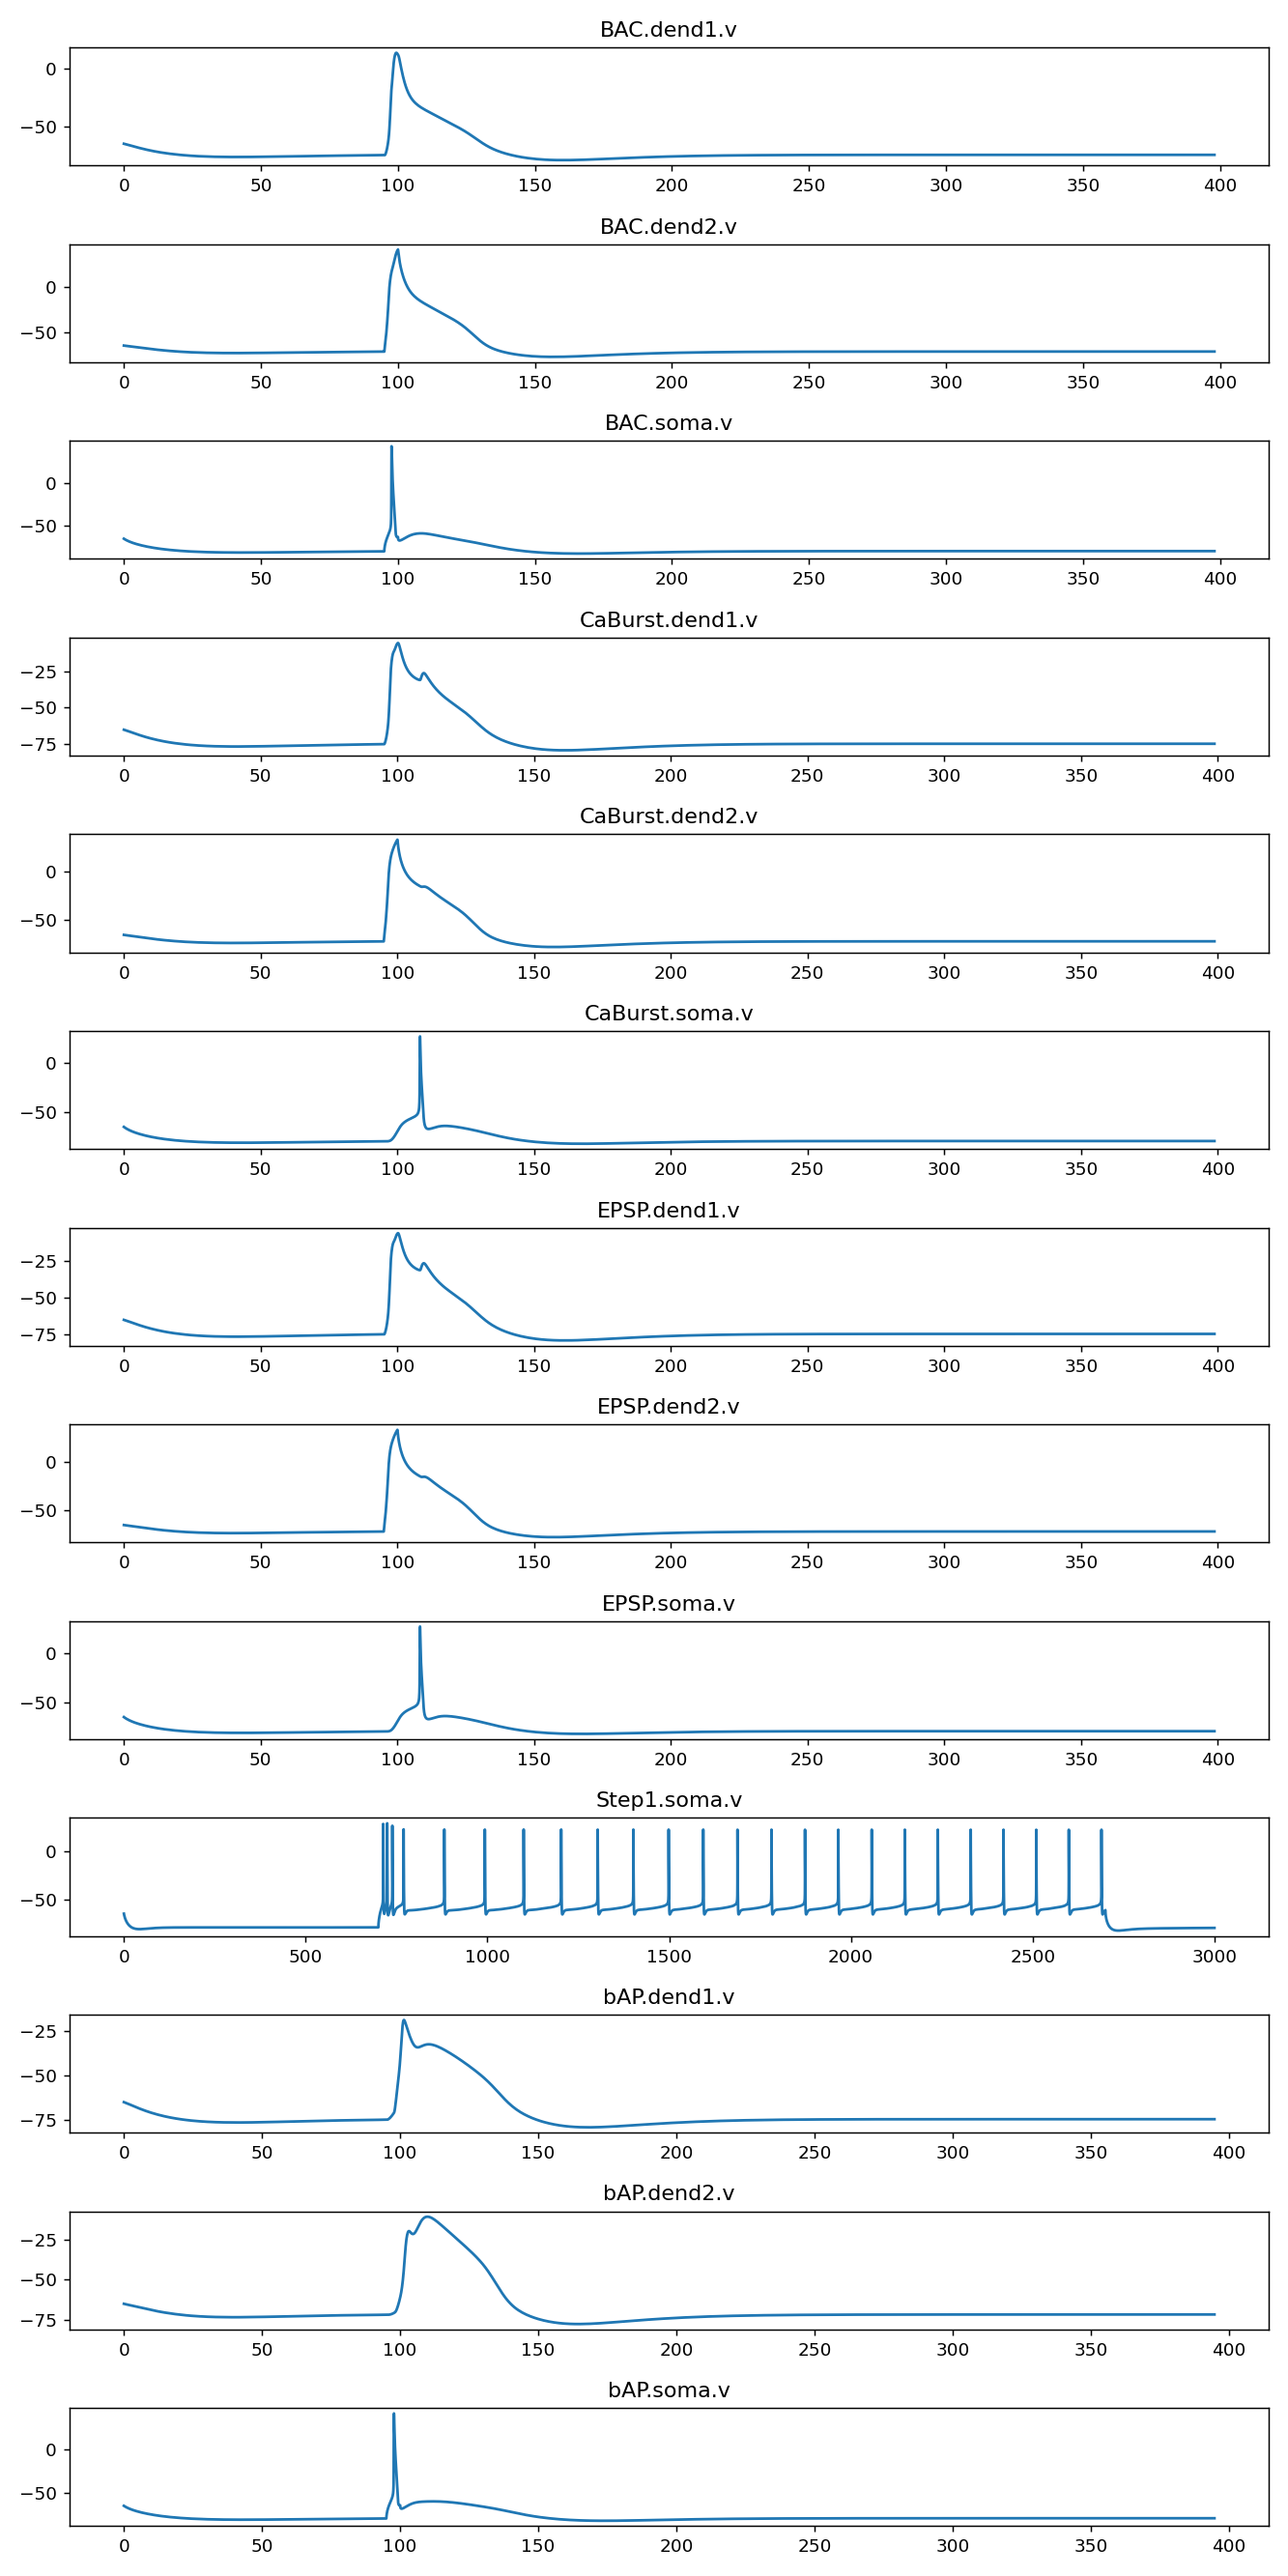

In [12]:
fig, axes = plt.subplots(len(responses), figsize=(10, 20), squeeze=False)
for index, (resp_name, response) in enumerate(sorted(responses.items())):
    axes[index, 0].plot(response['time'], response['voltage'], label=resp_name)
    axes[index, 0].set_title(resp_name)
fig.tight_layout()
fig.show()